In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm
import torch as torch
from datasets import load_dataset, load_from_disk
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
from datasets import load_dataset
import nltk
nltk.download('punkt')  # Download the necessary resources


from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature


from nltk.tokenize import sent_tokenize

import torch.nn.functional as F

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
path = "/om2/user/jackking/modular_transformers/scripts/attention_interpretability/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

max_length = 10

/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/jackking/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
fw = load_dataset("HuggingFaceFW/fineweb", name="sample-10BT", split="train", streaming=True)

In [3]:
fw_text = fw.select_columns("text")

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

sentences = []
for i, sample in enumerate(fw_text):
    #pull out any sentences are of length 10
    sample = sent_tokenize(sample["text"])
    length_8s = [tokenizer.encode(sentence) for sentence in sample if 10 <= len(tokenizer.encode(sentence)) <= 20]
    if length_8s:
        sentences.extend(length_8s)
    if len(sentences) > 10000:
        break

Token indices sequence length is longer than the specified maximum sequence length for this model (1050 > 1024). Running this sequence through the model will result in indexing errors


In [5]:
sentences = pickle.load(open(f"{path}data/{max_length}word_sentences.pkl", "rb"))
#choose 10000 random sentences
sentences = random.sample(sentences, 10000)
tokenized_sentences = [tokenizer.encode(sentence) for sentence in sentences]

In [6]:
model = GPT2LMHeadModel.from_pretrained("gpt2-xl")
model.to(device)

activations = compute_model_activations(model, tokenized_sentences, device)
curvatures = compute_model_curvature(activations)

100%|██████████| 10000/10000 [04:09<00:00, 40.03it/s]
10000it [01:48, 92.55it/s]


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

sentences = []
for i, sample in enumerate(fw_text):
    #pull out any sentences are of length 10
    sample = sent_tokenize(sample["text"])
    length_8s = [str(sentence) for sentence in sample if len(tokenizer.encode(sentence)) == max_length]
    if length_8s:
        sentences.extend(length_8s)
    if i % 5000 == 0:
        print(len(sentences))
    if len(sentences) > 200000:
        break

del fw_text
del fw


In [290]:
with open(f"{path}data/{max_length}word_sentences.pkl", "wb") as f:
    pickle.dump(sentences, f)

In [291]:
sentences = pickle.load(open(f"{path}data/{max_length}word_sentences.pkl", "rb"))

In [3]:
model = GPT2LMHeadModel.from_pretrained("gpt2-xl")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

In [293]:
batch_size = 64

class SentenceDataset(Dataset):
    def __init__(self, inputs, tokenizer, max_length):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        inputs = self.inputs[idx]
        return inputs

inputs = tokenizer(sentences, return_tensors="pt", max_length=max_length, truncation=True)["input_ids"]
dataset = SentenceDataset(inputs, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# finding the suprisal at each token given the full previous context

def get_whole_context_surprisals(model, dataloader, device):
    model.eval()
    surprisals = []
    for batch in tqdm(dataloader):
        inputs = batch.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        logits = outputs.logits
        log_probs = -F.log_softmax(logits, dim=-1)

        for i in range(inputs.shape[0]):
            #find the surprisal of each place in the context predicting the next token
            token_indices = inputs[i, 1:].cpu().numpy()
            token_log_probs = log_probs[i, torch.arange(len(token_indices)), token_indices]
            surprisals.append(token_log_probs.cpu().numpy())

    return surprisals

whole_context_surprisals = get_whole_context_surprisals(model, dataloader, device)

with open(f"{path}data/{max_length}word_whole_context_surprisals.pkl", "wb") as f:
    pickle.dump(whole_context_surprisals, f)

# finding the surprisal at each token given only the previous two tokens

def get_two_token_context_surprisals(model, dataloader, device):
    model.eval()
    surprisals = []
    for batch in tqdm(dataloader):
        #get every three token pair
        # shape: (batch_size, max_length-2, 3)
        batch = np.stack([batch[:, i:i+3] for i in range(max_length - 2)], axis=1)
        for sample in batch:
            inputs = torch.tensor(sample).to(device)
            with torch.no_grad():
                outputs = model(inputs)
            logits = outputs.logits
            log_probs = -F.log_softmax(logits, dim=-1)

            one_sentence = []

            for i in range(inputs.shape[0]):
                #for each three token string
                token_index = inputs[i, -1].cpu().numpy() #get the last token
                token_log_prob = log_probs[i, -2, token_index] #prob of the second to last token predicting the last token
                one_sentence.append(token_log_prob.item())

            surprisals.append(one_sentence)

    return surprisals

two_token_context_surprisals = get_two_token_context_surprisals(model, dataloader, device)

with open(f"{path}data/{max_length}word_two_token_context_surprisals.pkl", "wb") as f:
    pickle.dump(two_token_context_surprisals, f)


100%|██████████| 3126/3126 [1:27:49<00:00,  1.69s/it]


In [7]:
whole_context_surprisals = pickle.load(open(f"{path}data/{max_length}word_whole_context_surprisals.pkl", "rb"))
two_token_surprisals = pickle.load(open(f"{path}data/{max_length}word_two_token_context_surprisals.pkl", "rb"))
sentences = pickle.load(open(f"{path}data/{max_length}word_sentences.pkl", "rb"))

whole_context_surprisals = np.array(whole_context_surprisals)
two_token_surprisals = np.array(two_token_surprisals)

In [8]:
whole_context_surprisals = np.array(whole_context_surprisals)
two_token_surprisals = np.array(two_token_surprisals)

In [16]:
slow_sentences = []
whole_slow_surprisals = []
two_token_slow_surprisals = []
fast_sentences = []
whole_fast_surprisals = []
two_token_fast_surprisals = []

all_indivd_suprisals = []
for surprisal in whole_context_surprisals:
    all_indivd_suprisals.extend(surprisal)
all_indivd_suprisals = np.array(all_indivd_suprisals)
whole_suprisal_mean = np.mean(all_indivd_suprisals)
whole_surprisal_std = np.std(all_indivd_suprisals)

all_indivd_suprisals = []
for surprisal in two_token_surprisals:
    all_indivd_suprisals.extend(surprisal)
all_indivd_suprisals = np.array(all_indivd_suprisals)
two_token_suprisal_mean = np.mean(all_indivd_suprisals)
two_token_surprisal_std = np.std(all_indivd_suprisals)


def check_for_fast(whole_context_surprisal, two_token_surprisal):
    #whole context surprisal is high and limited (two token) context is low
    clause1 = np.all(whole_context_surprisal > whole_suprisal_mean - whole_surprisal_std*4/5) 
    clause2 = np.all(two_token_surprisal < (two_token_suprisal_mean + two_token_surprisal_std / 2))

    return clause1 and clause2

def check_for_fast(whole_context_surprisal, two_token_surprisal):
    #whole context surprisal is high and limited (two token) context is low
    clause1 = np.all(whole_context_surprisal > whole_suprisal_mean - whole_surprisal_std*4/5) 
    clause2 = np.all(two_token_surprisal < (two_token_suprisal_mean + two_token_surprisal_std / 2))

    return clause1 and clause2
                                                                
def check_for_slow(whole_context_surprisal, two_token_surprisal):
    # the last two tokens are low surprisal with full context
    clause1 = np.all(whole_context_surprisal[-2:] < whole_suprisal_mean - whole_surprisal_std / 3)

    # the third to last token is also low surprisal with full context
    clause3 = np.all(whole_context_surprisal[-4:-2] < whole_suprisal_mean)

    #in general the model does not have fast statistics
    clause2 = np.all(two_token_surprisal > two_token_suprisal_mean - two_token_surprisal_std*5/8) 

    #this is especially true for the last few tokens, because their prediction needs to come from slow context
    clause4 = np.all(two_token_surprisal[-3:] > two_token_suprisal_mean - two_token_surprisal_std*2/3)

    return clause1 and clause2 and clause3 and clause4

for sentence, whole_context_surprisal, two_token_surprisal in zip(sentences, whole_context_surprisals, two_token_surprisals):

    if check_for_slow(whole_context_surprisal, two_token_surprisal):
        slow_sentences.append(sentence)
        whole_slow_surprisals.append(whole_context_surprisal)
        two_token_slow_surprisals.append(two_token_surprisal)

    elif check_for_fast(whole_context_surprisal, two_token_surprisal):
        fast_sentences.append(sentence)
        whole_fast_surprisals.append(whole_context_surprisal)
        two_token_fast_surprisals.append(two_token_surprisal)

whole_fast_surprisals = np.array(whole_fast_surprisals)
two_token_fast_surprisals = np.array(two_token_fast_surprisals)
whole_slow_surprisals = np.array(whole_slow_surprisals)
two_token_slow_surprisals = np.array(two_token_slow_surprisals)


In [426]:
with open(f"{path}data/{max_length}word_fast_sentences.pkl", "wb") as f:
    pickle.dump(fast_sentences, f)

with open(f"{path}data/{max_length}word_slow_sentences.pkl", "wb") as f:
    pickle.dump(slow_sentences, f)

In [10]:
np.mean(two_token_fast_surprisals, axis=0), np.mean(two_token_slow_surprisals, axis=0)

(array([4.01389598, 4.32342577, 4.21109142, 4.27658027, 4.28165439,
        4.39243792, 4.95074194, 3.08637319]),
 array([7.79604695, 7.11290315, 7.30672771, 7.05997615, 5.35859721,
        5.76095426, 5.75607929, 4.72565308]))

In [11]:
np.mean(whole_fast_surprisals, axis=0), np.mean(whole_slow_surprisals, axis=0)

(array([5.8934116, 4.013897 , 4.0230184, 3.8677263, 3.8355782, 3.6650639,
        3.7639577, 3.8494933, 2.8098536], dtype=float32),
 array([5.7890863, 7.796048 , 5.939896 , 5.74578  , 5.2325873, 2.1280138,
        1.93645  , 1.3500495, 1.4147624], dtype=float32))

## Compare Curvature

In [18]:
model = GPT2LMHeadModel.from_pretrained("gpt2-xl")
model.to(device)

fast_sentences = [tokenizer.encode(fast_sentences[i]) for i in range(len(fast_sentences))]
activations = compute_model_activations(model, fast_sentences, device)
fast_curvature = compute_model_curvature(activations)

slow_sentences = [tokenizer.encode(slow_sentences[i]) for i in range(len(slow_sentences))]
activations = compute_model_activations(model, slow_sentences, device)
slow_curvature = compute_model_curvature(activations)

100%|██████████| 305/305 [00:07<00:00, 40.61it/s]
305it [00:03, 93.05it/s]
100%|██████████| 356/356 [00:08<00:00, 40.39it/s]
356it [00:03, 94.86it/s]


#### Curvature over all tokens in trajectory

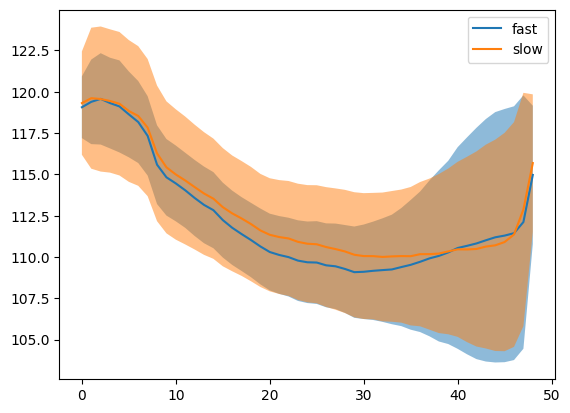

In [19]:
fast_curve = np.mean(fast_curvature["curve"], axis=1) / np.pi * 180
slow_curve = np.mean(slow_curvature["curve"], axis=1) / np.pi * 180
fast_curve_std = np.std(fast_curvature["curve"], axis=1) / np.pi * 180
slow_curve_std = np.std(slow_curvature["curve"], axis=1) / np.pi * 180
fast_curve_conf = 1.96 * fast_curve_std / np.sqrt(fast_curvature["curve"].shape[1])
slow_curve_conf = 1.96 * slow_curve_std / np.sqrt(slow_curvature["curve"].shape[1])
plt.plot(fast_curve, label="fast")
plt.plot(slow_curve, label="slow")
plt.fill_between(np.arange(len(fast_curve)), fast_curve - fast_curve_std, fast_curve + fast_curve_std, alpha=0.5)
plt.fill_between(np.arange(len(slow_curve)), slow_curve - slow_curve_std, slow_curve + slow_curve_std, alpha=0.5)
plt.legend()
plt.show()

#### Curvature over last four tokens

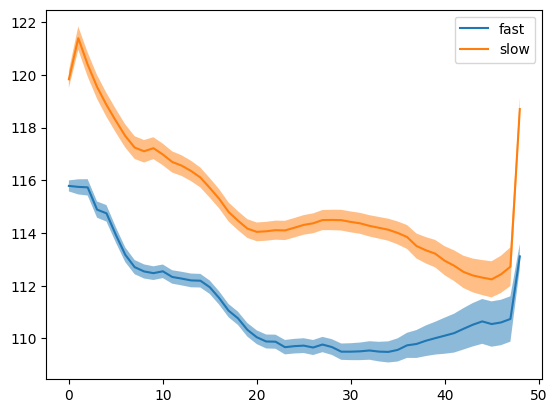

In [466]:
fast_curve = np.mean(np.mean(fast_curvature["all_layer_curve_all"], axis=0)[:, 1:2], axis = -1) / np.pi * 180
slow_curve = np.mean(np.mean(slow_curvature["all_layer_curve_all"], axis=0)[:, 1:2], axis = -1) / np.pi * 180
fast_curve_std = np.std(fast_curvature["curve"], axis=1) / np.pi * 180
slow_curve_std = np.std(slow_curvature["curve"], axis=1) / np.pi * 180
fast_curve_conf = 1.96 * fast_curve_std / np.sqrt(fast_curvature["curve"].shape[1])
slow_curve_conf = 1.96 * slow_curve_std / np.sqrt(slow_curvature["curve"].shape[1])
plt.plot(fast_curve, label="fast")
plt.plot(slow_curve, label="slow")
plt.fill_between(np.arange(len(fast_curve)), fast_curve - fast_curve_conf, fast_curve + fast_curve_conf, alpha=0.5)
plt.fill_between(np.arange(len(slow_curve)), slow_curve - slow_curve_conf, slow_curve + slow_curve_conf, alpha=0.5)
plt.legend()
plt.show()

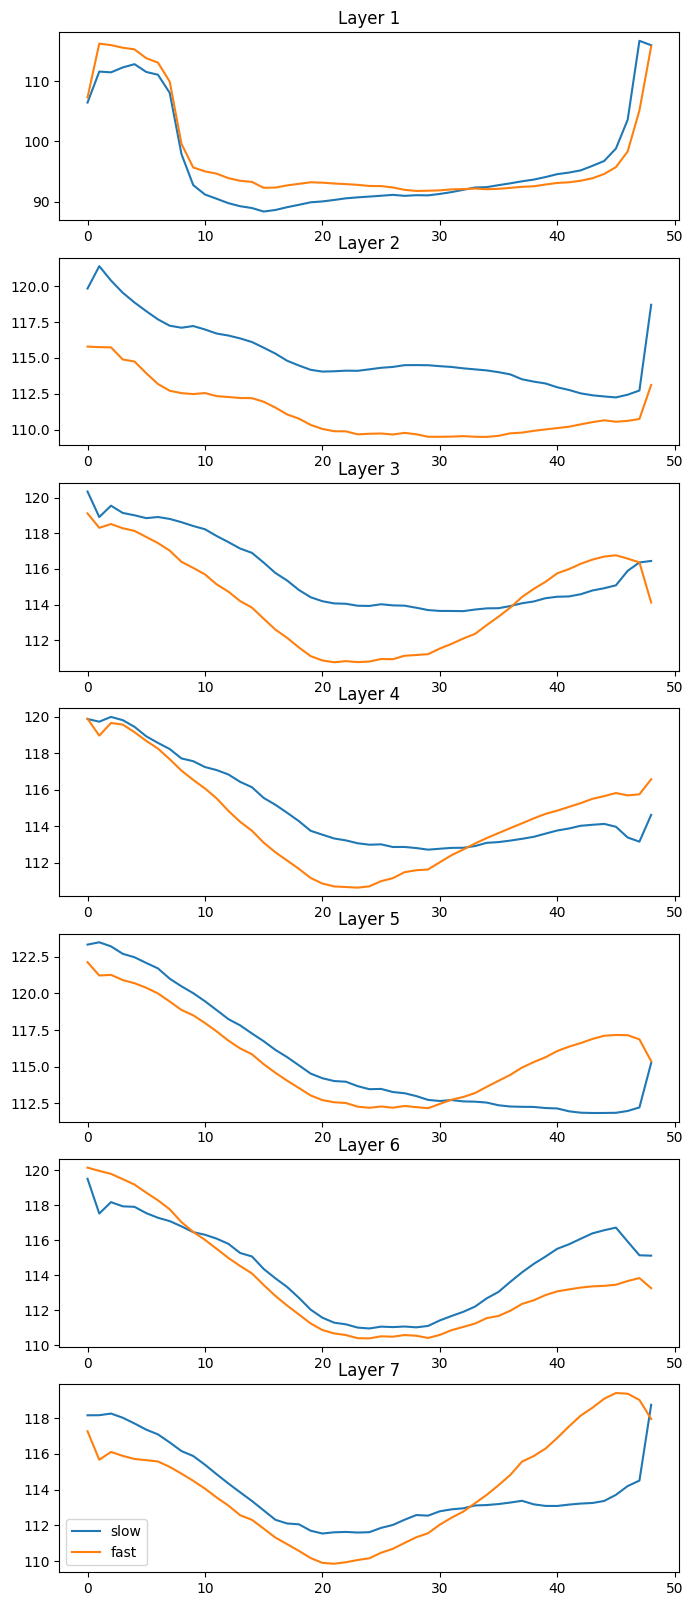

In [470]:
fig, axs = plt.subplots(7, 1, figsize=(8, 20))
for i in range(1, 8):
    curve = np.mean(np.mean(slow_curvature["all_layer_curve_all"], axis=0)[:, i-1:i], axis = -1) / np.pi * 180
    axs[i-1].plot(curve, label="slow")
    curve = np.mean(np.mean(fast_curvature["all_layer_curve_all"], axis=0)[:, i-1:i], axis = -1) / np.pi * 180
    axs[i-1].plot(curve, label="fast")
    axs[i-1].set_title(f"Layer {i}")

plt.legend()
plt.show()

In [ ]:
#functions for 8 token sentences

def check_for_fast(whole_context_surprisal, two_token_surprisal):
    #whole context surprisal is high and limited (two token) context is low
    clause1 = np.all(whole_context_surprisal > whole_suprisal_mean - whole_surprisal_std * 3/4) 
    clause2 = np.all(two_token_surprisal < two_token_suprisal_mean + two_token_surprisal_std / 3)

    return clause1 and clause2
                                                                
def check_for_slow(whole_context_surprisal, two_token_surprisal):
    # the last two tokens are low surprisal with full context but higher surprisal with limited context
    clause1 = np.all(whole_context_surprisal[-2:] < whole_suprisal_mean - whole_surprisal_std / 2)
    clause2 = np.all(two_token_surprisal[-2:] > two_token_suprisal_mean) 

    # the third to last token is also low surprisal with full context
    clause3 = whole_context_surprisal[-3] < whole_suprisal_mean

    #control for overall full context surprisal (want it to only be low for last few tokens)
    clause4 =  np.mean(whole_context_surprisal) > whole_suprisal_mean - whole_surprisal_std / 3

    return clause1 and clause2 and clause3 and clause4
